In [1]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.8 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sacremoses sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 16.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
import os

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, normalized_mutual_info_score, silhouette_score, calinski_harabasz_score
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
np.random.seed(42)
torch.manual_seed(42)

In [4]:
from transformers import MarianMTModel, MarianTokenizer

class BackTranslator:
    def __init__(self, device=None):
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.ru_en_model_name = 'Helsinki-NLP/opus-mt-ru-en'
        self.ru_en_tokenizer = MarianTokenizer.from_pretrained(self.ru_en_model_name)
        self.ru_en_model = MarianMTModel.from_pretrained(self.ru_en_model_name).to(self.device)

        self.en_ru_model_name = 'Helsinki-NLP/opus-mt-en-ru'
        self.en_ru_tokenizer = MarianTokenizer.from_pretrained(self.en_ru_model_name)
        self.en_ru_model = MarianMTModel.from_pretrained(self.en_ru_model_name).to(self.device)
        print(f"BackTranslator initialized on device: {self.device}")

    @torch.no_grad()
    def translate(self, texts, model, tokenizer, target_lang_token=None):
        model.eval()
        
        texts_to_translate = texts

        tokenized_texts = tokenizer(texts_to_translate, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.device)
        translated_tokens = model.generate(**tokenized_texts)
        translated_texts = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        return translated_texts

    def augment(self, russian_texts):
        if not isinstance(russian_texts, list):
            russian_texts = [russian_texts]

        english_texts = self.translate(russian_texts, self.ru_en_model, self.ru_en_tokenizer)

        augmented_russian_texts = self.translate(english_texts, self.en_ru_model, self.en_ru_tokenizer)

        return augmented_russian_texts

In [5]:
# back_translator = BackTranslator()

# original_texts = [
#     "Я люблю ходить в зал, но сегодня мой джим бро не смог прийти( я огорчён",
#     "Погода сегодня прекрасная, чтобы сдохнуть от жары, не так ли?"
# ]

# augmented_texts = back_translator.augment(original_texts)

# for orig, aug in zip(original_texts, augmented_texts):
#     print(f"Оригинал: {orig}")
#     print(f"Аугментация: {aug}\n")

In [4]:
import torch
from torch.utils.data import Dataset

class FiveDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_seq_len,
                 text_col='text', aug_text_col='augmented_text', target_col='rate'):
        self.data = dataframe
        self.original_texts = dataframe[text_col].tolist()
        if aug_text_col in dataframe.columns:
            self.augmented_texts = dataframe[aug_text_col].tolist()
            print(f"Found '{aug_text_col}' column for augmentations.")
        else:
            print(f"Warning: Column '{aug_text_col}' not found. Using original text as augmented view.")
            self.augmented_texts = self.original_texts # Fallback

        self.targets = None
        if target_col in dataframe.columns:
            self.targets = dataframe[target_col].tolist()

        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def _tokenize_text(self, text_str):
        text_str = str(text_str)
        text_for_tokenizer = ' '.join(text_str.split())
        inputs = self.tokenizer.encode_plus(
            text_for_tokenizer,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
        }

    def __getitem__(self, index):
        original_text_str = self.original_texts[index]
        augmented_text_str = self.augmented_texts[index]

        tokenized_original = self._tokenize_text(original_text_str)
        tokenized_augmented = self._tokenize_text(augmented_text_str)

        item = {
            'ids_orig': tokenized_original['ids'],
            'mask_orig': tokenized_original['mask'],
            'ids_aug': tokenized_augmented['ids'],
            'mask_aug': tokenized_augmented['mask'],
        }

        if self.targets is not None:
            item['targets'] = torch.tensor(self.targets[index], dtype=torch.long)
        
        return item

    def __len__(self) -> int:
        return len(self.original_texts)

In [5]:
class SupConLoss(torch.nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        logits = torch.matmul(features, features.T) / self.temperature

        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        pos_per_sample = mask.sum(1)
        pos_per_sample = torch.where(pos_per_sample < 1e-6,
                                   torch.ones_like(pos_per_sample),
                                   pos_per_sample)

        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mean_log_prob_pos = (mask * log_prob).sum(1) / pos_per_sample

        loss = -mean_log_prob_pos.mean()

        return loss

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class TotalContrastiveLoss(nn.Module):
    def __init__(self,
                 temperature_instance=0.07,
                 temperature_cluster=0.1,
                 lambda_kmeans=1.0,
                 lambda_cluster_contrastive=1.0,
                 lambda_instance_contrastive=1.0,
                 num_clusters=5,
                 hidden_norm_instance=True,
                 hidden_norm_cluster=True,
                 use_supervised_instance_loss=True):
        super().__init__()
        self.temperature_instance = temperature_instance
        self.temperature_cluster = temperature_cluster
        self.lambda_kmeans = lambda_kmeans
        self.lambda_cluster_contrastive = lambda_cluster_contrastive
        self.lambda_instance_contrastive = lambda_instance_contrastive
        self.num_clusters = num_clusters
        self.hidden_norm_instance = hidden_norm_instance
        self.hidden_norm_cluster = hidden_norm_cluster
        self.use_supervised_instance_loss = use_supervised_instance_loss

        self.verbose = True

    def _instance_contrastive_loss(self, h_orig, h_aug, labels=None):
        """
        Instance-level contrastive loss.
        Если labels is None (use_supervised_instance_loss=False), то это SimCLR.
        Если labels is not None (use_supervised_instance_loss=True), то это SupCon.
        """
        batch_size = h_orig.shape[0]
        device = h_orig.device

        if self.hidden_norm_instance:
            h_orig = F.normalize(h_orig, p=2, dim=1)
            h_aug = F.normalize(h_aug, p=2, dim=1)

        features = torch.cat([h_orig, h_aug], dim=0) # (2 * batch_size, feature_dim)
        sim_matrix = torch.matmul(features, features.T) / self.temperature_instance

        if self.use_supervised_instance_loss and labels is not None:
            # Supervised Contrastive Loss (SupCon)
            labels_cat = labels.contiguous().view(-1, 1)
            labels_expanded = torch.cat([labels_cat, labels_cat], dim=0) # (2 * batch_size, 1)
            
            # mask[i, j] = 1 if D[i] == D[j]
            mask = torch.eq(labels_expanded, labels_expanded.T).float().to(device)
            
            # Mask out diagonal (self-similarity) and also dissimilar classes for positive pairs
            logits_mask = torch.scatter(
                torch.ones_like(mask),
                1,
                torch.arange(2 * batch_size).view(-1, 1).to(device),
                0
            )
            mask = mask * logits_mask # Keep only positives from different views or same view if same class

            # For SupCon, positive pairs are all pairs from same class, excluding self.
            # Denominator includes all pairs except self.
            exp_logits = torch.exp(sim_matrix) * logits_mask
            log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True) + 1e-9)

            # Compute mean of log-likelihood over positive pairs
            # mask has 1s for all positive pairs (same class, not self)
            # For each anchor, sum its log_prob with other positives, divide by num_positives for that anchor
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-9) # Avoid division by zero
            loss = -mean_log_prob_pos.mean()

        else:
            # Unsupervised SimCLR-style loss
            # Positive pairs are (h_orig_i, h_aug_i)
            positive_indices = torch.zeros(2 * batch_size, dtype=torch.long, device=device)
            positive_indices[:batch_size] = torch.arange(batch_size, 2 * batch_size)
            positive_indices[batch_size:] = torch.arange(batch_size)

            logits_mask_simclr = torch.scatter(
                torch.ones_like(sim_matrix),
                1,
                torch.arange(2 * batch_size).view(-1, 1).to(device),
                0
            ) # Mask out diagonal for denominator

            exp_sim_matrix = torch.exp(sim_matrix) * logits_mask_simclr
            log_prob = sim_matrix - torch.log(exp_sim_matrix.sum(dim=1, keepdim=True) + 1e-9)
            loss = -log_prob.gather(dim=1, index=positive_indices.view(-1,1)).mean()
            
        return loss

    def _kmeans_style_loss(self, Z, Q): # Z: (batch, feat_dim), Q: (batch, num_clusters)
        # loss_km = Tr(Z^T Z) - Tr(Q^T Z^T Z Q)
        # Z: (N, D), Q: (N, K)
        ZTZ = Z.T @ Z # (D, D)
        loss_km = torch.trace(ZTZ) - torch.trace(Q.T @ Z @ Z.T @ Q) # Q.T @ Z @ Z.T @ Q -> (K,N)@(N,D)@(D,N)@(N,K) -> (K,K)
                                                                  # Q.T @ Z -> (K,D)
                                                                  # (Q.T @ Z) @ (Q.T @ Z).T = Q.T @ Z @ Z.T @ Q
        # Z Z^T (N, N) - матрица схожести между объектами. Q (N,K)
        loss_km_term = torch.trace(Z.T @ Z) - torch.trace(Q.T @ (Z @ Z.T) @ Q)
        return loss_km_term


    def _cluster_contrastive_loss_with_entropy(self, Q_orig, Q_aug):
        """
        Cluster-level contrastive loss + Entropy term H(q).
        Q_orig, Q_aug: (batch_size, num_clusters)
        """
        batch_size = Q_orig.shape[0]
        num_clusters = self.num_clusters
        device = Q_orig.device

        # Cluster representations are columns of Q.
        # Transpose Q to get cluster vectors as rows: (num_clusters, batch_size)
        q1_T = Q_orig.T # (K, N)
        q2_T = Q_aug.T   # (K, N)

        if self.hidden_norm_cluster: # Normalize cluster representations
            q1_T = F.normalize(q1_T, p=2, dim=1) # Normalize each cluster vector
            q2_T = F.normalize(q2_T, p=2, dim=1)

        features_cluster = torch.cat([q1_T, q2_T], dim=0) # (2 * K, N)
        
        # sim_matrix_cluster[i,j] = sim(cluster_rep_i, cluster_rep_j)
        sim_matrix_cluster = torch.matmul(features_cluster, features_cluster.T) / self.temperature_cluster # (2K, 2K)

        logits_mask_cluster = torch.scatter(
            torch.ones_like(sim_matrix_cluster),
            1,
            torch.arange(2 * num_clusters).view(-1, 1).to(device),
            0
        )
        positive_indices_cluster = torch.zeros(2 * num_clusters, dtype=torch.long, device=device)
        positive_indices_cluster[:num_clusters] = torch.arange(num_clusters, 2 * num_clusters)
        positive_indices_cluster[num_clusters:] = torch.arange(num_clusters)

        exp_sim_matrix_cluster = torch.exp(sim_matrix_cluster) * logits_mask_cluster
        log_prob_cluster = sim_matrix_cluster - torch.log(exp_sim_matrix_cluster.sum(dim=1, keepdim=True) + 1e-9)
        
        loss_cl_contrastive = -log_prob_cluster.gather(dim=1, index=positive_indices_cluster.view(-1,1)).mean()

        # Entropy

        F_orig_softmax = F.softmax(Q_orig.detach(), dim=1) # (batch, K)
        p_i_orig = F_orig_softmax.sum(dim=0) / (F_orig_softmax.sum() + 1e-9) 
        ne_i_orig = torch.log(torch.tensor(self.num_clusters, device=device).float()) + \
                    (p_i_orig * torch.log(p_i_orig + 1e-9)).sum()

        F_aug_softmax = F.softmax(Q_aug.detach(), dim=1) # (batch, K)
        p_i_aug = F_aug_softmax.sum(dim=0) / (F_aug_softmax.sum() + 1e-9)
        ne_i_aug = torch.log(torch.tensor(self.num_clusters, device=device).float()) + \
                   (p_i_aug * torch.log(p_i_aug + 1e-9)).sum()
        

        entropy_term_to_add = (ne_i_orig + ne_i_aug) / 2.0

        return loss_cl_contrastive + entropy_term_to_add

    def forward(self, features_orig, features_aug, Q_orig, Q_aug, labels_for_supcon=None):
        loss_instance = self._instance_contrastive_loss(features_orig, features_aug, labels_for_supcon)
        
        loss_kmeans_orig = self._kmeans_style_loss(features_orig.detach(), Q_orig)
        loss_kmeans_aug = self._kmeans_style_loss(features_aug.detach(), Q_aug)
        total_kmeans_loss = (loss_kmeans_orig + loss_kmeans_aug) / 2.0
        
        # Cluster contrastive loss using Q matrices
        loss_cluster_w_entropy = self._cluster_contrastive_loss_with_entropy(Q_orig, Q_aug)

        total_loss = (self.lambda_instance_contrastive * loss_instance +
                      self.lambda_kmeans * total_kmeans_loss +
                      self.lambda_cluster_contrastive * loss_cluster_w_entropy)
        
        if self.verbose and torch.rand(1) < 0.01 :
             print(f"Losses Inst: {loss_instance.item():.4f}, KM: {total_kmeans_loss.item():.4f}, Clus+Ent: {loss_cluster_w_entropy.item():.4f}")

        return total_loss

In [40]:
import torch
from transformers import AutoModel
from typing import Dict


class ModelForClassification(torch.nn.Module):
    def __init__(self, model_path: str, config: Dict, freeze_bert_layers=False, use_classifier=False):
        super().__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(model_path)
        if model_path == "cointegrated/rubert-tiny2":
            for name, param in self.bert.named_parameters():
              if 'encoder.layer.2' not in name and 'encoder.layer.1' not in name:
                  param.requires_grad = False
        if model_path == "RussianNLP/ruRoBERTa-large-rucola":
            for name, param in self.bert.named_parameters():
              if 'encoder.layer.22' not in name and 'encoder.layer.23' not in name:
                  param.requires_grad = False
        if freeze_bert_layers:
            for param in self.bert.parameters():
                param.requires_grad = False
        total_params = sum(p.numel() for p in self.bert.parameters())
        trainable_params = sum(p.numel() for p in self.bert.parameters() if p.requires_grad)
        print(f"Всего параметров: {total_params:,}")
        print(f"Обучаемых параметров: {trainable_params:,} ({trainable_params/total_params:.1%})")
        bert_output_size = self.bert.config.hidden_size
        print(bert_output_size)
        self.use_classifier = use_classifier
        
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(bert_output_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 192),
            torch.nn.LayerNorm(192),
        )
        
        for layer in self.projection_head:
          if isinstance(layer, torch.nn.Linear):
              torch.nn.init.kaiming_normal_(layer.weight)
        if self.use_classifier:
            self.classifier = torch.nn.Sequential(
                torch.nn.Linear(192, 128),
                torch.nn.Dropout(self.dropout_rate),
                torch.nn.Linear(128, self.n_classes),
            )
            for layer in self.classifier:
                if isinstance(layer, torch.nn.Linear):
                    torch.nn.init.xavier_normal_(layer.weight)
                    if layer.bias is not None:
                        torch.nn.init.zeros_(layer.bias)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]
        projection = self.projection_head(hidden_state)
        # out = torch.nn.functional.normalize(projection, p=2, dim=1)
        if self.use_classifier:
            return self.classifier(projection)
        return projection

In [37]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch import optim 
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

class Trainer:
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.max_epochs = config['max_epochs']
        self.name_for_save = config['name_for_save']
        self.long_term_training = config['long_term_training']
        self.patience = config.get('patience', 0)
        self.optimizer = config['optimizer']
        self.scheduler = config['scheduler']
        self.num_clusters_for_loss = config.get('num_clusters_for_loss', 5)
        self.model = None
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_f1': [],
            'val_f1': [],
            'train_acc': [],
            'val_acc': [],
            'train_nmi': [],
            'val_nmi': [],
            'train_silhouette' : [],
            'val_silhouette' : [],
            'train_calinski_harabasz' : [],
            'val_calinski_harabasz' : [],
        }
        self.loss_fn = None
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        self.best_val_loss = float('inf')
        self.best_val_f1 = -float('inf')
        self.best_val_acc = -float('inf')
        self.best_val_nmi = -float('inf')
        self.lrs = []

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        num_epochs = self.n_epochs
        patience_counter = 0
        epoch = 0
        while epoch < num_epochs and epoch < self.max_epochs:
            print(f"Epoch {epoch + 1}/{num_epochs}")

            train_info = self.train_epoch(train_dataloader, epoch)

            val_info = self.val_epoch(val_dataloader, epoch)

            for key in train_info:
                if key in self.history:
                    self.history[key].append(train_info[key])
            for key in val_info:
                if key in self.history:
                    self.history[key].append(val_info[key])

            log_str = f"train_loss: {train_info['train_loss']:.4f}"
            log_str += f", val_loss: {val_info['val_loss']:.4f}"

            if 'train_f1' in train_info:
                log_str += f", train_f1: {train_info['train_f1']:.4f}"
            if 'val_f1' in val_info:
                log_str += f", val_f1: {val_info['val_f1']:.4f}"
                
            if 'train_acc' in train_info:
                log_str += f", train_acc: {train_info['train_acc']:.4f}"
            if 'val_acc' in val_info:
                log_str += f", val_acc: {val_info['val_acc']:.4f}"

            if 'train_nmi' in train_info:
                log_str += f", train_nmi: {train_info['train_nmi']:.4f}"
            if 'val_nmi' in val_info:
                log_str += f", val_nmi: {val_info['val_nmi']:.4f}"

            if 'train_silhouette' in train_info:
                log_str += f", train_silhouette: {train_info['train_silhouette']:.4f}"
            if 'val_silhouette' in val_info:
                log_str += f", val_silhouette: {val_info['val_silhouette']:.4f}"
                
            if 'train_calinski_harabasz' in train_info:
                log_str += f", train_calinski_harabasz: {train_info['train_calinski_harabasz']:.4f}"
            if 'val_calinski_harabasz' in val_info:
                log_str += f", val_calinski_harabasz: {val_info['val_calinski_harabasz']:.4f}"

            print(log_str)

            if val_info['val_loss'] < self.best_val_loss:
                self.best_val_loss = val_info['val_loss']
                self.save(f"best_model_val_{self.name_for_save}.pt")
                print("Модель сохранена с наименьшим лосом", self.best_val_loss)
                patience_counter = 0
                if (epoch + self.patience) > num_epochs and self.long_term_training:
                    num_epochs += (epoch + self.patience) - num_epochs
            if 'val_f1' in val_info and val_info['val_f1'] > self.best_val_f1:
                self.best_val_f1 = val_info['val_f1']
                self.save(f"best_model_val_f1_{self.name_for_save}.pt")
                print("Модель сохранена с лучшим скором f1", self.best_val_f1)
                patience_counter = 0
                if (epoch + self.patience) > num_epochs and self.long_term_training:
                    num_epochs += (epoch + self.patience) - num_epochs
            if 'val_acc' in val_info and val_info['val_acc'] > self.best_val_acc:
                self.best_val_acc = val_info['val_acc']
                self.save(f"best_model_val_acc_{self.name_for_save}.pt")
                print("Модель сохранена с лучшим скором acc", self.best_val_acc)
                patience_counter = 0
                if (epoch + self.patience) > num_epochs and self.long_term_training:
                    num_epochs += (epoch + self.patience) - num_epochs
            if 'val_nmi' in val_info and val_info['val_nmi'] > self.best_val_nmi:
                self.best_val_nmi = val_info['val_nmi']
                self.save(f"best_model_val_nmi_{self.name_for_save}.pt")
                print("Модель сохранена с лучшим скором nmi", self.best_val_nmi)
                patience_counter = 0
                if (epoch + self.patience) > num_epochs and self.long_term_training:
                    num_epochs += (epoch + self.patience) - num_epochs
            patience_counter += 1
            epoch +=1
            if epoch == num_epochs: self.save(f"model_last_epoch_{self.name_for_save}.pt")
            self.lrs.append(self.optimizer.param_groups[0]["lr"])
            if self.scheduler is not None:
                if isinstance(self.scheduler, (optim.lr_scheduler.OneCycleLR, optim.lr_scheduler.CyclicLR)) and \
                   getattr(self.scheduler, 'step_mode', 'epoch') == 'batch':
                     self.scheduler.step()

        self.visualize_history()
        return self.model.eval()

    def train_epoch(self, train_dataloader, epoch):
        self.model.train()
        losses_epoch = []
        all_preds = []
        all_labels = []
        list_of_features_orig_from_batches = []
        true_labels_for_orig = []
        class_counts = torch.zeros(5, device=self.device)
    
        if self.verbose:
            train_dataloader_pbar = tqdm(train_dataloader, desc="Training Epoch")
        else:
            train_dataloader_pbar = train_dataloader
    
        for batch_idx, batch in enumerate(train_dataloader_pbar):
            ids_orig = batch['ids_orig'].to(self.device)
            mask_orig = batch['mask_orig'].to(self.device)
            ids_aug = batch['ids_aug'].to(self.device)
            mask_aug = batch['mask_aug'].to(self.device)
            
            targets = batch.get('targets', None)
            if targets is not None:
                targets = targets.to(self.device)
                true_labels_for_orig.append(targets.detach())

            unique, counts = torch.unique(targets, return_counts=True)
            class_counts[unique] += counts.float()
    
            features_orig = self.model(ids_orig, mask_orig)
            features_aug = self.model(ids_aug, mask_aug)
    
            self.optimizer.zero_grad()
            list_of_features_orig_from_batches.append(features_orig.detach())
    
            if isinstance(self.loss_fn, TotalContrastiveLoss):
                with torch.no_grad():
                    U_orig, _, _ = torch.linalg.svd(features_orig.detach(), full_matrices=False)
                    Q_orig = U_orig[:, :self.num_clusters_for_loss]
                    U_aug, _, _ = torch.linalg.svd(features_aug.detach(), full_matrices=False)
                    Q_aug = U_aug[:, :self.num_clusters_for_loss]
                
                current_loss = self.loss_fn(features_orig, features_aug, Q_orig, Q_aug, 
                                            targets if self.loss_fn.use_supervised_instance_loss else None)
            
            elif isinstance(self.loss_fn, SupConLoss):
                 combined_features = torch.cat([features_orig, features_aug], dim=0)
                 if targets is None: raise ValueError("SupConLoss requires targets.")
                 combined_targets = torch.cat([targets, targets], dim=0)
                 current_loss = self.loss_fn(combined_features, combined_targets)
            
            elif isinstance(self.loss_fn, CrossEntropyLoss):
                combined_features = torch.cat([features_orig, features_aug], dim=0)
                if targets is None: raise ValueError("CrossEntropyLoss requires targets.")
                combined_targets = torch.cat([targets, targets], dim=0)
                current_loss = self.loss_fn(combined_features, combined_targets)
            else:
                raise NotImplementedError(f"Loss function {type(self.loss_fn)} not supported.")
    
            current_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            losses_epoch.append(current_loss.item())

            if isinstance(self.loss_fn, CrossEntropyLoss):
                preds = combined_features.argmax(dim=1)
                all_preds.append(preds.cpu())
                all_labels.append(combined_targets.cpu())
            
            if self.verbose:
                 train_dataloader_pbar.set_postfix(loss=current_loss.item())
                
        result = {'train_loss': np.mean(losses_epoch)}
        if isinstance(self.loss_fn, TotalContrastiveLoss):
            all_features_orig = torch.cat(list_of_features_orig_from_batches).cpu().numpy()
            all_true_labels_val = torch.cat(true_labels_for_orig).cpu().numpy()
            features_for_clustering_eval = all_features_orig
            if len(features_for_clustering_eval) > 1 and epoch % 3 == 0: 
                num_clusters_eval = self.num_clusters_for_loss
                kmeans = KMeans(n_clusters=num_clusters_eval, random_state=42, n_init='auto')
                cluster_labels_pred = kmeans.fit_predict(features_for_clustering_eval)
            
                if len(np.unique(cluster_labels_pred)) > 1:
                    try:
                        silhouette_avg = silhouette_score(features_for_clustering_eval, cluster_labels_pred)
                        result['train_silhouette'] = silhouette_avg
                        print(f"Train Silhouette Score: {silhouette_avg:.4f}")
                    except ValueError as e:
                        print(f"Could not compute silhouette score: {e}")
                    
                    try:
                        calinski_harabasz = calinski_harabasz_score(features_for_clustering_eval, cluster_labels_pred)
                        result['train_calinski_harabasz'] = calinski_harabasz
                        print(f"Train calinski_harabasz Index: {calinski_harabasz:.4f}")
                    except ValueError as e:
                        print(f"Could not compute calinski_harabasz score: {e}")
                if all_true_labels_val is not None and len(all_true_labels_val) == len(cluster_labels_pred):
                    try:
                        nmi_score_val = normalized_mutual_info_score(all_true_labels_val, cluster_labels_pred)
                        result['train_nmi'] = nmi_score_val
                    except Exception as e:
                        print(f"Error computing NMI: {e}")
                    
        
        if isinstance(self.loss_fn, CrossEntropyLoss):
            all_preds = torch.cat(all_preds).cpu().numpy()
            all_labels = torch.cat(all_labels).cpu().numpy()
            result['train_f1'] = f1_score(all_labels, all_preds, average='weighted')
            result['train_acc'] = accuracy_score(all_labels, all_preds)
            result['train_nmi'] = normalized_mutual_info_score(all_labels, all_preds)
            print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

        total_samples = class_counts.sum().item()
        class_distribution = (class_counts / total_samples * 100).cpu().numpy()

        print("\nTrain Class Distribution:")
        for i, percent in enumerate(class_distribution):
            print(f"Class {i}: {percent:.1f}%")
            
        return result

    def val_epoch(self, val_dataloader, epoch):
        self.model.eval()
        losses_epoch_val = []
        all_preds = []
        all_labels = []
        list_of_features_orig_from_batches = []
        true_labels_for_orig = []
        class_counts = torch.zeros(5, device=self.device)
        
        if self.verbose:
            val_dataloader_pbar = tqdm(val_dataloader, desc="Validation Epoch")
        else:
            val_dataloader_pbar = val_dataloader
    
        with torch.no_grad():
            for batch in val_dataloader_pbar:
                ids_orig = batch['ids_orig'].to(self.device)
                mask_orig = batch['mask_orig'].to(self.device)
                ids_aug = batch['ids_aug'].to(self.device)
                mask_aug = batch['mask_aug'].to(self.device)
                targets = batch.get('targets', None)
                if targets is not None:
                    targets = targets.to(self.device)
                    true_labels_for_orig.append(targets.detach())

                unique, counts = torch.unique(targets, return_counts=True)
                class_counts[unique] += counts.float()
    
                features_orig = self.model(ids_orig, mask_orig)
                features_aug = self.model(ids_aug, mask_aug)

                list_of_features_orig_from_batches.append(features_orig.detach())
    
                if isinstance(self.loss_fn, TotalContrastiveLoss):
                    U_orig, _, _ = torch.linalg.svd(features_orig, full_matrices=False)
                    Q_orig = U_orig[:, :self.num_clusters_for_loss]
                    U_aug, _, _ = torch.linalg.svd(features_aug, full_matrices=False)
                    Q_aug = U_aug[:, :self.num_clusters_for_loss]
                    current_loss = self.loss_fn(features_orig, features_aug, Q_orig, Q_aug,
                                                targets if self.loss_fn.use_supervised_instance_loss else None)
                
                elif isinstance(self.loss_fn, SupConLoss):
                     combined_features = torch.cat([features_orig, features_aug], dim=0)
                     if targets is None: raise ValueError("SupConLoss requires targets.")
                     combined_targets = torch.cat([targets, targets], dim=0)
                     current_loss = self.loss_fn(combined_features, combined_targets)
                elif isinstance(self.loss_fn, CrossEntropyLoss):
                    combined_features = torch.cat([features_orig, features_aug], dim=0)
                    if targets is None: raise ValueError("CrossEntropyLoss requires targets.")
                    combined_targets = torch.cat([targets, targets], dim=0)
                    current_loss = self.loss_fn(combined_features, combined_targets)
                else:
                     raise NotImplementedError(f"Loss function {type(self.loss_fn)} for validation not supported.")
                
                losses_epoch_val.append(current_loss.item())
                if self.verbose:
                    val_dataloader_pbar.set_postfix(loss=current_loss.item())

                if isinstance(self.loss_fn, CrossEntropyLoss):
                    preds = combined_features.argmax(dim=1)
                    all_preds.append(preds.cpu())
                    all_labels.append(combined_targets.cpu())

        result = {'val_loss': np.mean(losses_epoch_val)}
        if isinstance(self.loss_fn, TotalContrastiveLoss):
            all_features_orig = torch.cat(list_of_features_orig_from_batches).cpu().numpy()
            all_true_labels_val = torch.cat(true_labels_for_orig).cpu().numpy()
            features_for_clustering_eval = all_features_orig
            if len(features_for_clustering_eval) > 1 and epoch % 3 == 0: 
                num_clusters_eval = self.num_clusters_for_loss
                kmeans = KMeans(n_clusters=num_clusters_eval, random_state=42, n_init='auto')
                cluster_labels_pred = kmeans.fit_predict(features_for_clustering_eval)
            
                if len(np.unique(cluster_labels_pred)) > 1:
                    try:
                        silhouette_avg = silhouette_score(features_for_clustering_eval, cluster_labels_pred)
                        result['val_silhouette'] = silhouette_avg
                        print(f"Validation Silhouette Score: {silhouette_avg:.4f}")
                    except ValueError as e:
                        print(f"Could not compute silhouette score: {e}")
                    
                    try:
                        calinski_harabasz = calinski_harabasz_score(features_for_clustering_eval, cluster_labels_pred)
                        result['val_calinski_harabasz'] = calinski_harabasz
                        print(f"Validation calinski_harabasz Index: {calinski_harabasz:.4f}")
                    except ValueError as e:
                        print(f"Could not compute calinski_harabasz score: {e}")
                    if all_true_labels_val is not None and len(all_true_labels_val) == len(cluster_labels_pred):
                        try:
                            nmi_score_val = normalized_mutual_info_score(all_true_labels_val, cluster_labels_pred)
                            result['val_nmi'] = nmi_score_val
                        except Exception as e:
                            print(f"Error computing NMI: {e}")
        
        # print(losses)
        if isinstance(self.loss_fn, CrossEntropyLoss):
            all_preds = torch.cat(all_preds).cpu().numpy()
            all_labels = torch.cat(all_labels).cpu().numpy()
            result['val_f1'] = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            result['val_acc'] = accuracy_score(all_labels, all_preds)
            result['val_nmi'] = normalized_mutual_info_score(all_labels, all_preds)
            print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

        total_samples = class_counts.sum().item()
        class_distribution = (class_counts / total_samples * 100).cpu().numpy()

        print("\nTrain Class Distribution:")
        for i, percent in enumerate(class_distribution):
            print(f"Class {i}: {percent:.1f}%")
            
        return result

    def visualize_history(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 3, 1)
        if 'train_loss' in self.history and len(self.history['train_loss']) > 0:
            plt.plot(self.history['train_loss'], label='Train Loss')
        if 'val_loss' in self.history and len(self.history['val_loss']) > 0:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        if 'train_f1' in self.history and len(self.history['train_f1']) > 0:
            plt.plot(self.history['train_f1'], label='Train F1', color='red')
        if 'val_f1' in self.history and len(self.history['val_f1']) > 0:
            plt.plot(self.history['val_f1'], label='Validation F1', color='blue')
        if 'train_acc' in self.history and len(self.history['train_acc']) > 0:
            plt.plot(self.history['train_acc'], label='Train ACC', color='green')
        if 'val_acc' in self.history and len(self.history['val_acc']) > 0:
            plt.plot(self.history['val_acc'], label='Validation ACC', color='orange')
        plt.title('Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()

        plt.subplot(1, 3, 3)
        if 'train_nmi' in self.history and len(self.history['train_nmi']) > 0:
            plt.plot(self.history['train_nmi'], label='Train NMI', color='red')
        if 'val_nmi' in self.history and len(self.history['val_nmi']) > 0:
            plt.plot(self.history['val_nmi'], label='Validation NMI', color='blue')
        # if 'train_calinski_harabasz' in self.history and len(self.history['train_calinski_harabasz']) > 0:
        #     plt.plot(self.history['train_calinski_harabasz'], label='Train calinski_harabasz', color='green')
        # if 'val_calinski_harabasz' in self.history and len(self.history['val_calinski_harabasz']) > 0:
        #     plt.plot(self.history['val_calinski_harabasz'], label='Validation calinski_harabasz', color='orange')

        if 'train_silhouette' in self.history and len(self.history['train_silhouette']) > 0:
            plt.plot(self.history['train_silhouette'], label='Train silhouette', color='pink')
        if 'val_silhouette' in self.history and len(self.history['val_silhouette']) > 0:
            plt.plot(self.history['val_silhouette'], label='Validation silhouette', color='black')
        plt.title('Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.plot(self.lrs, label="Learning Rate")
        plt.xlabel('Epochs')
        plt.ylabel('Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str, tune=False):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"],
            freeze_bert_layers=tune
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [9]:
from torch.utils.data import WeightedRandomSampler

In [10]:
def create_balanced_dataloader(dataset, target_column, class_weights, batch_size):
    targets = dataset.data[target_column].values

    sample_weights = [class_weights[class_id] for class_id in targets]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=True
    )

In [11]:
def auto_class_weights(dataset, batch_size, target_column='rate'):
    targets = dataset.data[target_column].values

    class_counts = np.bincount(targets)

    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

    sample_weights = [class_weights[class_id] for class_id in targets]

    sampler =  WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    return DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=0,
            pin_memory=True
        )


In [12]:
MAX_LEN = 512
BATCH_SIZE = 256

In [13]:
PATH = "../input/data-data"

In [14]:
# tokenizer = AutoTokenizer.from_pretrained(
#     "RussianNLP/ruRoBERTa-large-rucola", truncation=True, do_lower_case=True)

tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
!cp ../input/augmentation_utils.py ../working

In [ ]:
from augmentation_utils import augment_worker, BackTranslator
import torch.multiprocessing as mp
import pandas as pd
import torch
import numpy as np
import os

if __name__ == "__main__":
    try:
        mp.set_start_method('spawn', force=True)
        print("Multiprocessing start method set to 'spawn'")
    except RuntimeError:
        print("Multiprocessing start method already set or could not be set to 'spawn'.")
    
    try:
        mp.set_start_method('spawn', force=True)
        print("Multiprocessing start method set to 'spawn'")
    except RuntimeError:
        print("Multiprocessing start method already set or could not be set to 'spawn'.")


    original_df = pd.read_csv(os.path.join(PATH, "train.csv"))
    print(original_df.shape)

    original_df['text_length'] = original_df['text'].astype(str).apply(len)
    original_df = original_df[original_df['text_length'] > 50]
    original_df = original_df[original_df['text_length'] < 512]
    print(original_df.shape)
    original_df = original_df.reset_index(drop=True)

    if original_df.empty:
        print("DataFrame is empty after filtering. Exiting.")
        exit()

    print(f"Total texts to augment after filtering: {len(original_df)}")

    num_gpus = torch.cuda.device_count()
    if num_gpus == 0:
        print("No GPUs found! Running on CPU (this will be slow and is not parallelized here).")
        back_translator_cpu = BackTranslator(device_name='cpu')
        all_texts_to_process = original_df['text'].tolist()
        augmented_texts_list_cpu = []
        batch_size_for_augmentation_cpu = 16 # Меньше для CPU
        for i in tqdm(range(0, len(all_texts_to_process), batch_size_for_augmentation_cpu), desc="CPU Augmentation"):
            batch = all_texts_to_process[i:i+batch_size_for_augmentation_cpu]
            augmented_texts_list_cpu.extend(back_translator_cpu.augment_batch(batch))
        original_df['augmented_text'] = augmented_texts_list_cpu

    elif num_gpus > 0 :
        print(f"Found {num_gpus} GPUs. Will use {min(num_gpus, 2)} for augmentation.")
        gpus_to_use = min(num_gpus, 2)

        all_texts_list = original_df['text'].tolist()
        print(len(all_texts_list))
        text_chunks = np.array_split(all_texts_list, gpus_to_use)
        # print(text_chunks[:2])
        
        print(f"Number of chunks: {len(text_chunks)}")
        for idx, chunk in enumerate(text_chunks):
            print(f"Chunk {idx} size: {len(chunk)}")

        batch_size_per_gpu_augmentation = 32
        pool_args = []
        for i in range(gpus_to_use):
            device_name = f'cuda:{i}'
            if len(text_chunks[i]) > 0:
                  pool_args.append((i, device_name, text_chunks[i].tolist(), batch_size_per_gpu_augmentation))
            else:
                print(f"Skipping GPU {i} as its chunk is empty.")
        
        if not pool_args:
            print("No data to process after chunking. Exiting.")
            exit()

        print(f"Starting augmentation on {len(pool_args)} GPUs...")
        with mp.Pool(processes=len(pool_args)) as pool:
            # map или starmap. starmap удобнее, если у функции несколько аргументов
            results_from_pool = pool.starmap(augment_worker, pool_args)


        final_augmented_texts_list = []
        for res_list in results_from_pool:
            final_augmented_texts_list.extend(res_list)
        
        print(f"Total augmented texts collected: {len(final_augmented_texts_list)}")
        print(f"Expected texts (original df size): {len(original_df)}")

        if len(final_augmented_texts_list) == len(original_df):
            original_df['augmented_text'] = final_augmented_texts_list
        else:
            print("Error: Mismatch in lengths of original and augmented texts after parallel processing!")
            print("This might happen if a worker process failed.")
            if len(final_augmented_texts_list) > 0 and len(final_augmented_texts_list) < len(original_df):
                  print(f"Padding augmented list with None to match original length for saving.")
                  padding_needed = len(original_df) - len(final_augmented_texts_list)
                  final_augmented_texts_list.extend([None] * padding_needed)
                  original_df['augmented_text'] = final_augmented_texts_list
            elif len(final_augmented_texts_list) == 0 and len(original_df) > 0:
                  print("All workers might have failed. No augmented texts collected.")


    if 'augmented_text' in original_df.columns:
        try:
            original_df.to_csv("train_with_augmentations_parallel.csv", index=False)
            print(f"Augmented data saved to {save_path}")
        except Exception as e:
            print(f"Error saving augmented data: {e}")
    else:
        print("Column 'augmented_text' not found in DataFrame. Skipping save.")

    print("Augmentation process finished.")


In [29]:
# back_translator = BackTranslator()
# original_df = pd.read_csv(os.path.join(PATH, "train.csv"))
# original_df['text_length'] = original_df['text'].apply(len)

# original_df = original_df[50 < original_df['text_length']]
# original_df = original_df[original_df['text_length'] < 500]

# augmented_texts_list = []
# batch_size_for_augmentation = 32

# for i in tqdm(range(0, len(original_df), batch_size_for_augmentation)):
#     batch_texts = original_df['text'].iloc[i:i+batch_size_for_augmentation].tolist()
#     augmented_batch = back_translator.augment(batch_texts)
#     augmented_texts_list.extend(augmented_batch)

# original_df['augmented_text'] = augmented_texts_list
# train_data = original_df

In [ ]:
# original_df.to_csv("train_with_augmentations.csv", index=False)

In [30]:
# train_data.head(10)

In [ ]:
# original_df = pd.read_csv(os.path.join(PATH, "test.csv"))

# augmented_texts_list = []
# batch_size_for_augmentation = 128

# for i in tqdm(range(0, len(original_df), batch_size_for_augmentation)):
#     batch_texts = original_df['text'].iloc[i:i+batch_size_for_augmentation].tolist()
#     augmented_batch = back_translator.augment(batch_texts)
#     augmented_texts_list.extend(augmented_batch)

# original_df['augmented_text'] = augmented_texts_list
# test_data = original_df

In [19]:
# data = pd.read_csv(os.path.join(PATH, "train_with_augmentations_parallel.csv"))
# data['aug_length'] = data['augmented_text'].apply(len)

In [32]:
# data['length_diff'] = np.abs(data['text_length'] - data['aug_length'])

# condition_to_replace = data['length_diff'] > 40


# data.loc[condition_to_replace, 'augmented_text'] = data.loc[condition_to_replace, 'text']


# num_replaced = condition_to_replace.sum()
# print(f"Количество аугментаций, замененных оригинальным текстом: {num_replaced}")

# data.to_csv("augs_with_replaces.csv")

Количество аугментаций, замененных оригинальным текстом: 14110


In [35]:
# data = data[50 < data['text_length']]
# data = data[data['text_length'] < 512]

In [36]:
# data.shape

(33736, 6)

In [37]:
# data['length_diff'] = np.abs(data['text_length'] - data['aug_length'])

# condition_to_replace = data['length_diff'] > 40


# data.loc[condition_to_replace, 'augmented_text'] = data.loc[condition_to_replace, 'text']


# num_replaced = condition_to_replace.sum()
# print(f"Количество аугментаций, замененных оригинальным текстом: {num_replaced}")

Количество аугментаций, замененных оригинальным текстом: 10650


In [ ]:
train_data = pd.read_csv(os.path.join(PATH, "train_with_augmentations_parallel.csv"))
test_data = pd.read_csv(os.path.join(PATH, "test.csv"))

print(train_data.shape)
train_data['text_length'] = train_data['text'].apply(len)

train_data = train_data[50 < train_data['text_length']]
train_data = train_data[train_data['text_length'] < 512]
print(train_data.shape)
le = LabelEncoder()

train_data.rate = le.fit_transform(train_data.rate)
train_split, val_split = train_test_split(train_data, test_size=0.2, stratify=train_data['rate'], random_state=42)

train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN, 
                                text_col='text', aug_text_col='augmented_text', target_col='rate')
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN,
                              text_col='text', aug_text_col='augmented_text', target_col='rate')
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN,
                              text_col='text', aug_text_col='augmented_text')

In [16]:
joblib.dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [17]:
train_params = {"batch_size": BATCH_SIZE,
               "shuffle": True,
               "num_workers": 4
               }

In [18]:
val_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 4
               }

In [19]:
test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 4
               }

In [20]:
train_dataloader = DataLoader(train_dataset, **train_params) # auto_class_weights(train_dataset, BATCH_SIZE, target_column='rate')

val_dataloader = DataLoader(val_dataset, **val_params)  #auto_class_weights(val_dataset, BATCH_SIZE, target_column='rate') #DataLoader(val_dataset, **val_params) 

test_dataloader = DataLoader(test_dataset, **test_params)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
eps=1e-8

Всего параметров: 29,193,768
Обучаемых параметров: 1,534,368 (5.3%)
312
Epoch 1/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Train Silhouette Score: 0.1948
Train calinski_harabasz Index: 14551.7583

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Losses Inst: 6.0275, KM: 210.3359, Clus+Ent: 0.0007
Losses Inst: 5.9954, KM: 204.6758, Clus+Ent: 0.0007
Validation Silhouette Score: 0.3936
Validation calinski_harabasz Index: 13752.4488

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 19.3362, val_loss: 10.0028, train_nmi: 0.2371, val_nmi: 0.2958, train_silhouette: 0.1948, val_silhouette: 0.3936, train_calinski_harabasz: 14551.7583, val_calinski_harabasz: 13752.4488
Модель сохранена с наименьшим лосом 10.002771607151738
Модель сохранена с лучшим скором nmi 0.2958328636568911
Epoch 2/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 6.0490, KM: 378.5176, Clus+Ent: 9.1702
Losses Inst: 5.9778, KM: 461.2363, Clus+Ent: 2.3752
Losses Inst: 6.0434, KM: 520.8047, Clus+Ent: 4.3019
Losses Inst: 5.9870, KM: 538.3926, Clus+Ent: 4.7962

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 17.2991, val_loss: 12.6496
Epoch 3/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.9547, KM: 582.5449, Clus+Ent: 1.9639
Losses Inst: 5.9641, KM: 577.8984, Clus+Ent: 2.4252

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 20.0236, val_loss: 15.7500
Epoch 4/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.8487, KM: 734.7949, Clus+Ent: 1.6956
Train Silhouette Score: 0.2633
Train calinski_harabasz Index: 23487.8946

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Losses Inst: 6.0145, KM: 472.4336, Clus+Ent: 0.0007
Validation Silhouette Score: 0.3500
Validation calinski_harabasz Index: 9330.3751

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.2226, val_loss: 15.2922, train_nmi: 0.3406, val_nmi: 0.3100, train_silhouette: 0.2633, val_silhouette: 0.3500, train_calinski_harabasz: 23487.8946, val_calinski_harabasz: 9330.3751
Модель сохранена с лучшим скором nmi 0.30995002759273427
Epoch 5/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.8601, KM: 677.8203, Clus+Ent: 3.6168

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Losses Inst: 6.0040, KM: 466.7773, Clus+Ent: 0.0007

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.6047, val_loss: 15.7875
Epoch 6/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.9299, KM: 819.7422, Clus+Ent: 1.8596
Losses Inst: 5.9027, KM: 729.8105, Clus+Ent: 3.8023
Losses Inst: 5.9498, KM: 688.9746, Clus+Ent: 1.8953
Losses Inst: 5.8343, KM: 670.3164, Clus+Ent: 6.6633

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Losses Inst: 5.9987, KM: 471.3633, Clus+Ent: 0.0007
Losses Inst: 6.0219, KM: 524.3398, Clus+Ent: 0.0007
Losses Inst: 6.0504, KM: 467.9258, Clus+Ent: 0.0007

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.4800, val_loss: 15.1081
Epoch 7/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Train Silhouette Score: 0.3115
Train calinski_harabasz Index: 30370.2281

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Silhouette Score: 0.3714
Validation calinski_harabasz Index: 10726.4721

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.1850, val_loss: 15.9284, train_nmi: 0.3945, val_nmi: 0.3110, train_silhouette: 0.3115, val_silhouette: 0.3714, train_calinski_harabasz: 30370.2281, val_calinski_harabasz: 10726.4721
Модель сохранена с лучшим скором nmi 0.31097642777993817
Epoch 8/16


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.7927, KM: 802.1328, Clus+Ent: 3.1896

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.4937, val_loss: 16.8528
Epoch 9/16


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 23.3744, val_loss: 16.0696
Epoch 10/16


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.8479, KM: 687.7344, Clus+Ent: 4.2051
Train Silhouette Score: 0.3421
Train calinski_harabasz Index: 34299.5574

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Silhouette Score: 0.3952
Validation calinski_harabasz Index: 11992.2443

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.4421, val_loss: 16.7203, train_nmi: 0.4366, val_nmi: 0.3117, train_silhouette: 0.3421, val_silhouette: 0.3952, train_calinski_harabasz: 34299.5574, val_calinski_harabasz: 11992.2443
Модель сохранена с лучшим скором nmi 0.31174429915902796
Epoch 11/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.7688, KM: 734.8848, Clus+Ent: 6.0617
Losses Inst: 5.7925, KM: 769.7734, Clus+Ent: 2.3340

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 23.0836, val_loss: 15.6564
Epoch 12/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.7343, KM: 735.9492, Clus+Ent: 5.3264
Losses Inst: 5.8290, KM: 682.0840, Clus+Ent: 8.4223
Losses Inst: 5.7006, KM: 799.0156, Clus+Ent: 0.8865

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.6931, val_loss: 15.8555
Epoch 13/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.6770, KM: 765.5664, Clus+Ent: 3.6884
Train Silhouette Score: 0.3632
Train calinski_harabasz Index: 38862.0689

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Silhouette Score: 0.4348
Validation calinski_harabasz Index: 12492.8114

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 23.3873, val_loss: 17.1807, train_nmi: 0.4804, val_nmi: 0.3021, train_silhouette: 0.3632, val_silhouette: 0.4348, train_calinski_harabasz: 38862.0689, val_calinski_harabasz: 12492.8114
Epoch 14/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.7117, KM: 705.4844, Clus+Ent: 6.6996

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 22.6179, val_loss: 16.0577
Epoch 15/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 5.6844, KM: 718.1328, Clus+Ent: 4.2035

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Losses Inst: 6.2292, KM: 536.5547, Clus+Ent: 0.0007

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 23.8345, val_loss: 16.2675
Epoch 16/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Train Silhouette Score: 0.3869
Train calinski_harabasz Index: 40633.9206

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Silhouette Score: 0.4208
Validation calinski_harabasz Index: 11926.6780

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 24.0976, val_loss: 17.5128, train_nmi: 0.5271, val_nmi: 0.2968, train_silhouette: 0.3869, val_silhouette: 0.4208, train_calinski_harabasz: 40633.9206, val_calinski_harabasz: 11926.6780
Epoch 17/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Losses Inst: 4.7818, KM: 275.5146, Clus+Ent: 2.2250

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 24.9166, val_loss: 17.4394
Epoch 18/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 24.5866, val_loss: 17.7753
Epoch 19/19


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

Train Silhouette Score: 0.3957
Train calinski_harabasz Index: 41651.6087

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Validation Silhouette Score: 0.4308
Validation calinski_harabasz Index: 12122.2785

Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 24.7227, val_loss: 17.9529, train_nmi: 0.5628, val_nmi: 0.2923, train_silhouette: 0.3957, val_silhouette: 0.4308, train_calinski_harabasz: 41651.6087, val_calinski_harabasz: 12122.2785


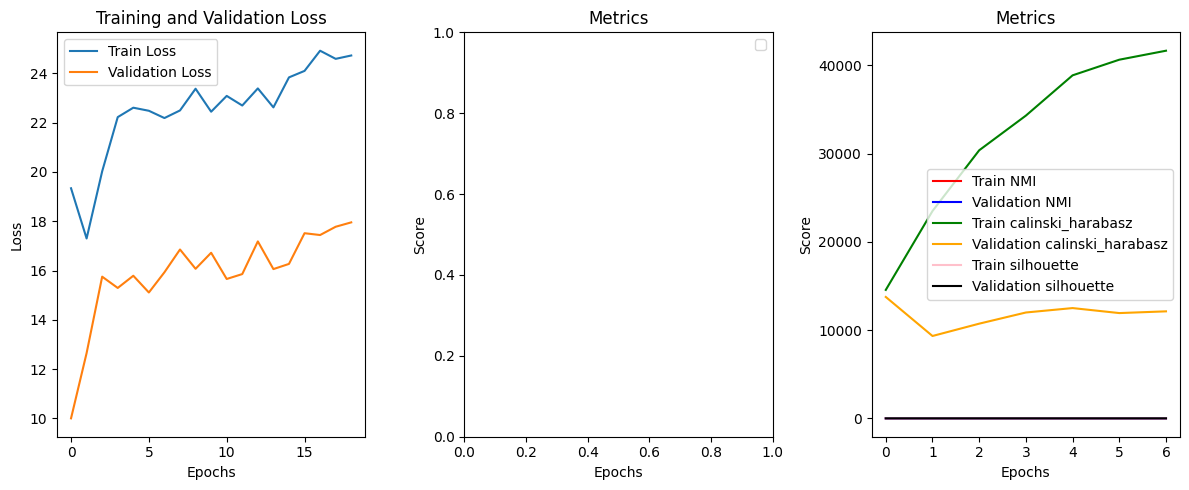

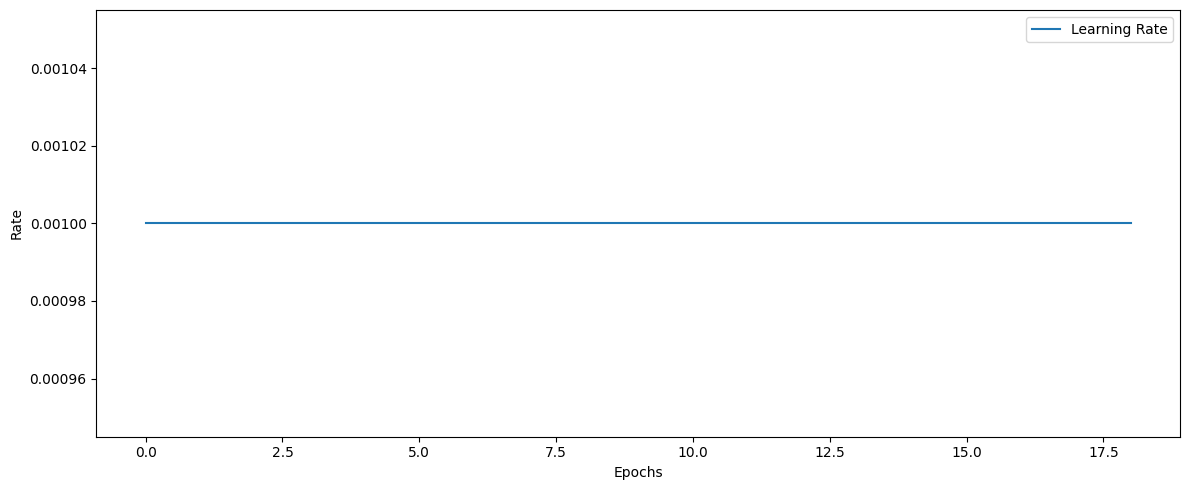

ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, ele

In [38]:
phase1_config = {
    "num_classes": 5,
    "dropout_rate": 0.1
}

# model_phase1 = ModelForClassification(
#     "RussianNLP/ruRoBERTa-large-rucola",
#     config=phase1_config,
#     freeze_bert_layers=False,
#     use_projection=True
# )

model_phase1 = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=phase1_config,
    freeze_bert_layers=False,
    use_classifier=False
)

opt1 = optim.AdamW(filter(lambda p: p.requires_grad, model_phase1.parameters()), lr=1e-3, weight_decay=1e-3)
trainer_config = {
    "n_epochs": 15,
    "max_epochs": 20,
    "name_for_save" : "phase1_TotalContrastiveLoss",
    "batch_size": BATCH_SIZE,
    "device": device,
    "long_term_training" : True,
    "patience": 10,
    "optimizer" : opt1,
    "scheduler" : None, # optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=self.n_epochs / 8, eta_min=1e-3 * 1e-4)
    
}

trainer_phase1 = Trainer(trainer_config)

trainer_phase1.loss_fn = TotalContrastiveLoss(
        temperature_instance=0.1,
        temperature_cluster=0.1,
        lambda_kmeans=2e-2,            
        lambda_cluster_contrastive=0.5, 
        lambda_instance_contrastive=1.0, 
        num_clusters=5,
        use_supervised_instance_loss= ('rate' in train_data.columns) # True, если есть метки
    ).to(device)
trainer_phase1.loss_fn.verbose = True

# trainer_phase1.loss_fn = SupConLoss(temperature=0.05)
trainer_phase1.fit(model_phase1, train_dataloader, val_dataloader)

In [45]:
phase2_config = {
    "num_classes": 5,
    "dropout_rate": 0.3
}

model_phase2 = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=phase2_config,
    freeze_bert_layers=False,
    use_classifier=True
)

# checkpoint = torch.load("best_model_val_loss.pt")
# state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith('bert')}
# model_phase2.load_state_dict(state_dict, strict=False)

checkpoint = torch.load("./best_model_val_nmi_phase1_TotalContrastiveLoss.pt")
model_phase1_state_dict = checkpoint['model_state_dict']

new_state_dict_for_phase2 = model_phase2.state_dict()

# Copy BERT weights
for key in model_phase1_state_dict:
    if key.startswith('bert.'):
        if key in new_state_dict_for_phase2:
            new_state_dict_for_phase2[key] = model_phase1_state_dict[key]

# Copy Projection Head weights
for key in model_phase1_state_dict:
    if key.startswith('projection_head.'):
         if key in new_state_dict_for_phase2:
            new_state_dict_for_phase2[key] = model_phase1_state_dict[key]

print("Freezing BERT and Projection Head layers for initial classifier training...")
for name, param in model_phase2.named_parameters():
    if name.startswith('bert.') or name.startswith('projection_head.'):
        param.requires_grad = False
    else:
        param.requires_grad = True # Убедимся, что веса классификатора обучаемы


trainable_params_after_freeze = sum(p.numel() for p in model_phase2.parameters() if p.requires_grad)
total_params_phase2 = sum(p.numel() for p in model_phase2.parameters())
print(f"Model_phase2: Total parameters: {total_params_phase2:,}")
print(f"Model_phase2: Trainable parameters after freezing: {trainable_params_after_freeze:,} ({trainable_params_after_freeze/total_params_phase2:.2%})")



Всего параметров: 29,193,768
Обучаемых параметров: 1,534,368 (5.3%)
312
Freezing BERT and Projection Head layers for initial classifier training...
Model_phase2: Total parameters: 29,348,973
Model_phase2: Trainable parameters after freezing: 25,349 (0.09%)


<ipython-input-45-562cbcd04f12>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./best_model_val_nmi_phase1_TotalContrastiveLoss.pt")


In [ ]:
opt2 = optim.AdamW(filter(lambda p: p.requires_grad, model_phase2.parameters()), lr=1e-3, weight_decay=1e-3)


trainer_phase2 = Trainer({
    "n_epochs": 10,
    "max_epochs": 20,
    "name_for_save" : "phase2_CrossEntropyLoss",
    "batch_size": BATCH_SIZE,
    "device": device,
    "long_term_training" : True,
    "patience": 10,
    "optimizer" : opt2,
    "scheduler" : None,  # optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=self.n_epochs / 8, eta_min=1e-3 * 1e-4)
})
trainer_phase2.loss_fn = CrossEntropyLoss()
trainer_phase2.fit(model_phase2, train_dataloader, DataLoader(val_dataset, **val_params))

Epoch 1/10


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.3605    0.3146    0.3360      4952
           1     0.1439    0.0563    0.0810      3018
           2     0.2685    0.2238    0.2441      7262
           3     0.3275    0.2774    0.3003     11674
           4     0.6617    0.7952    0.7223     27070

    accuracy                         0.5209     53976
   macro avg     0.3524    0.3335    0.3368     53976
weighted avg     0.4799    0.5209    0.4954     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4375    0.6333    0.5175      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3364    0.1993    0.2503      1816
           3     0.4042    0.3920    0.3981      2918
           4     0.7377    0.8484    0.7892      6768

    accuracy                         0.5951     13496
   macro avg     0.3832    0.4146    0.3910     13496
weighted avg     0.5427    0.5951    0.5630     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.2325, val_loss: 1.0106, train_f1: 0.4954, val_f1: 0.5630, train_acc: 0.5209, val_acc: 0.5951, train_nmi: 0.0952, val_nmi: 0.2010
Модель сохранена с наименьшим лосом 1.0105567155060944
Модель сохранена с лучшим скором f1 0.5629741178634928
Модель сохранена с лучшим скором acc 0.5951393005334914
Модель сохранена с лучшим скором nmi 0.20104019645636154
Epoch 2/10


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4415    0.4420    0.4418      4952
           1     0.1920    0.0716    0.1043      3018
           2     0.3171    0.2608    0.2862      7262
           3     0.3797    0.2830    0.3243     11674
           4     0.6861    0.8419    0.7560     27070

    accuracy                         0.5631     53976
   macro avg     0.4033    0.3799    0.3825     53976
weighted avg     0.5201    0.5631    0.5342     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4820    0.5848    0.5285      1238
           1     0.1000    0.0053    0.0101       756
           2     0.3527    0.2544    0.2956      1816
           3     0.4305    0.2611    0.3251      2918
           4     0.6874    0.9013    0.7800      6768

    accuracy                         0.5966     13496
   macro avg     0.4105    0.4014    0.3878     13496
weighted avg     0.5351    0.5966    0.5502     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0731, val_loss: 0.9929, train_f1: 0.5342, val_f1: 0.5502, train_acc: 0.5631, val_acc: 0.5966, train_nmi: 0.1457, val_nmi: 0.1958
Модель сохранена с наименьшим лосом 0.9928590500796283
Модель сохранена с лучшим скором acc 0.5966212211025489
Epoch 3/11


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4608    0.4919    0.4759      4952
           1     0.2152    0.0553    0.0880      3018
           2     0.3355    0.2804    0.3055      7262
           3     0.3995    0.2925    0.3377     11674
           4     0.6932    0.8526    0.7647     27070

    accuracy                         0.5768     53976
   macro avg     0.4208    0.3946    0.3944     53976
weighted avg     0.5335    0.5768    0.5462     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4509    0.6527    0.5333      1238
           1     0.2727    0.0079    0.0154       756
           2     0.3662    0.1883    0.2487      1816
           3     0.4103    0.2961    0.3439      2918
           4     0.7003    0.8942    0.7855      6768

    accuracy                         0.5981     13496
   macro avg     0.4401    0.4078    0.3854     13496
weighted avg     0.5458    0.5981    0.5515     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0414, val_loss: 0.9894, train_f1: 0.5462, val_f1: 0.5515, train_acc: 0.5768, val_acc: 0.5981, train_nmi: 0.1617, val_nmi: 0.2033
Модель сохранена с наименьшим лосом 0.9893735007003501
Модель сохранена с лучшим скором acc 0.5981031416716064
Модель сохранена с лучшим скором nmi 0.20328925699030484
Epoch 4/12


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4623    0.5048    0.4826      4952
           1     0.1914    0.0471    0.0755      3018
           2     0.3372    0.2735    0.3020      7262
           3     0.4025    0.2849    0.3337     11674
           4     0.6926    0.8615    0.7679     27070

    accuracy                         0.5794     53976
   macro avg     0.4172    0.3944    0.3923     53976
weighted avg     0.5329    0.5794    0.5464     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5070    0.5880    0.5445      1238
           1     0.3077    0.0106    0.0205       756
           2     0.3642    0.1817    0.2425      1816
           3     0.4135    0.2687    0.3257      2918
           4     0.6705    0.9146    0.7737      6768

    accuracy                         0.5957     13496
   macro avg     0.4526    0.3927    0.3814     13496
weighted avg     0.5384    0.5957    0.5422     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0317, val_loss: 0.9915, train_f1: 0.5464, val_f1: 0.5422, train_acc: 0.5794, val_acc: 0.5957, train_nmi: 0.1665, val_nmi: 0.1912
Epoch 5/12


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4686    0.5192    0.4926      4952
           1     0.2612    0.0444    0.0759      3018
           2     0.3442    0.2816    0.3098      7262
           3     0.4107    0.2890    0.3393     11674
           4     0.6942    0.8673    0.7712     27070

    accuracy                         0.5855     53976
   macro avg     0.4358    0.4003    0.3977     53976
weighted avg     0.5409    0.5855    0.5512     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5266    0.5444    0.5353      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3217    0.4791    0.3850      1816
           3     0.4515    0.3283    0.3802      2918
           4     0.7643    0.8345    0.7979      6768

    accuracy                         0.6039     13496
   macro avg     0.4128    0.4373    0.4197     13496
weighted avg     0.5725    0.6039    0.5832     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0208, val_loss: 0.9962, train_f1: 0.5512, val_f1: 0.5832, train_acc: 0.5855, val_acc: 0.6039, train_nmi: 0.1733, val_nmi: 0.2242
Модель сохранена с лучшим скором f1 0.5832104581207077
Модель сохранена с лучшим скором acc 0.6038826318909306
Модель сохранена с лучшим скором nmi 0.22415235925722268
Epoch 6/14


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4712    0.5258    0.4970      4952
           1     0.2353    0.0331    0.0581      3018
           2     0.3439    0.2941    0.3171      7262
           3     0.4166    0.2906    0.3423     11674
           4     0.6955    0.8651    0.7711     27070

    accuracy                         0.5864     53976
   macro avg     0.4325    0.4017    0.3971     53976
weighted avg     0.5415    0.5864    0.5522     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4954    0.6058    0.5451      1238
           1     0.4000    0.0053    0.0104       756
           2     0.3578    0.2093    0.2641      1816
           3     0.4057    0.4071    0.4064      2918
           4     0.7314    0.8626    0.7916      6768

    accuracy                         0.6046     13496
   macro avg     0.4781    0.4180    0.4035     13496
weighted avg     0.5705    0.6046    0.5710     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0145, val_loss: 0.9822, train_f1: 0.5522, val_f1: 0.5710, train_acc: 0.5864, val_acc: 0.6046, train_nmi: 0.1751, val_nmi: 0.2128
Модель сохранена с наименьшим лосом 0.9821681336120323
Модель сохранена с лучшим скором acc 0.6046235921754594
Epoch 7/15


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4735    0.5382    0.5038      4952
           1     0.2378    0.0355    0.0617      3018
           2     0.3413    0.2764    0.3054      7262
           3     0.4235    0.2971    0.3492     11674
           4     0.6931    0.8661    0.7700     27070

    accuracy                         0.5872     53976
   macro avg     0.4338    0.4026    0.3980     53976
weighted avg     0.5418    0.5872    0.5525     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4833    0.6317    0.5476      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3336    0.4394    0.3793      1816
           3     0.4351    0.3585    0.3931      2918
           4     0.7792    0.8153    0.7968      6768

    accuracy                         0.6034     13496
   macro avg     0.4062    0.4490    0.4234     13496
weighted avg     0.5740    0.6034    0.5859     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0114, val_loss: 0.9976, train_f1: 0.5525, val_f1: 0.5859, train_acc: 0.5872, val_acc: 0.6034, train_nmi: 0.1762, val_nmi: 0.2274
Модель сохранена с лучшим скором f1 0.5858507808287604
Модель сохранена с лучшим скором nmi 0.22743716022963917
Epoch 8/16


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4798    0.5353    0.5061      4952
           1     0.2178    0.0219    0.0397      3018
           2     0.3486    0.2979    0.3213      7262
           3     0.4188    0.2858    0.3397     11674
           4     0.6942    0.8714    0.7728     27070

    accuracy                         0.5892     53976
   macro avg     0.4319    0.4024    0.3959     53976
weighted avg     0.5419    0.5892    0.5529     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4804    0.6333    0.5463      1238
           1     0.5000    0.0026    0.0053       756
           2     0.3546    0.2941    0.3215      1816
           3     0.4320    0.3660    0.3963      2918
           4     0.7379    0.8593    0.7940      6768

    accuracy                         0.6079     13496
   macro avg     0.5010    0.4311    0.4127     13496
weighted avg     0.5832    0.6079    0.5775     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0080, val_loss: 0.9798, train_f1: 0.5529, val_f1: 0.5775, train_acc: 0.5892, val_acc: 0.6079, train_nmi: 0.1787, val_nmi: 0.2159
Модель сохранена с наименьшим лосом 0.9798336625099182
Модель сохранена с лучшим скором acc 0.6078838174273858
Epoch 9/17


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4754    0.5513    0.5105      4952
           1     0.2346    0.0202    0.0372      3018
           2     0.3556    0.2961    0.3231      7262
           3     0.4202    0.3020    0.3514     11674
           4     0.6984    0.8653    0.7730     27070

    accuracy                         0.5908     53976
   macro avg     0.4368    0.4070    0.3990     53976
weighted avg     0.5457    0.5908    0.5560     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4851    0.6317    0.5488      1238
           1     0.2273    0.0529    0.0858       756
           2     0.3709    0.2357    0.2882      1816
           3     0.4234    0.3297    0.3707      2918
           4     0.7191    0.8800    0.7915      6768

    accuracy                         0.6052     13496
   macro avg     0.4452    0.4260    0.4170     13496
weighted avg     0.5593    0.6052    0.5710     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0037, val_loss: 0.9803, train_f1: 0.5560, val_f1: 0.5710, train_acc: 0.5908, val_acc: 0.6052, train_nmi: 0.1812, val_nmi: 0.2128
Epoch 10/17


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4793    0.5571    0.5153      4952
           1     0.2085    0.0146    0.0273      3018
           2     0.3524    0.2885    0.3173      7262
           3     0.4193    0.3014    0.3507     11674
           4     0.6970    0.8670    0.7728     27070

    accuracy                         0.5908     53976
   macro avg     0.4313    0.4057    0.3967     53976
weighted avg     0.5433    0.5908    0.5549     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5375    0.5557    0.5465      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3519    0.2852    0.3151      1816
           3     0.4231    0.2282    0.2965      2918
           4     0.6751    0.9143    0.7767      6768

    accuracy                         0.5972     13496
   macro avg     0.3975    0.3967    0.3870     13496
weighted avg     0.5267    0.5972    0.5461     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 0.9999, val_loss: 0.9873, train_f1: 0.5549, val_f1: 0.5461, train_acc: 0.5908, val_acc: 0.5972, train_nmi: 0.1815, val_nmi: 0.1987
Epoch 11/17


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4839    0.5561    0.5175      4952
           1     0.3209    0.0199    0.0374      3018
           2     0.3520    0.3054    0.3270      7262
           3     0.4223    0.2880    0.3424     11674
           4     0.6961    0.8701    0.7734     27070

    accuracy                         0.5919     53976
   macro avg     0.4550    0.4079    0.3996     53976
weighted avg     0.5501    0.5919    0.5555     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5111    0.5929    0.5490      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3641    0.2522    0.2980      1816
           3     0.4319    0.2762    0.3370      2918
           4     0.6871    0.9072    0.7820      6768

    accuracy                         0.6030     13496
   macro avg     0.3989    0.4057    0.3932     13496
weighted avg     0.5338    0.6030    0.5555     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0000, val_loss: 0.9843, train_f1: 0.5555, val_f1: 0.5555, train_acc: 0.5919, val_acc: 0.6030, train_nmi: 0.1836, val_nmi: 0.2048
Epoch 12/17


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4794    0.5537    0.5139      4952
           1     0.2541    0.0156    0.0293      3018
           2     0.3613    0.3005    0.3281      7262
           3     0.4235    0.2952    0.3479     11674
           4     0.6949    0.8700    0.7726     27070

    accuracy                         0.5923     53976
   macro avg     0.4426    0.4070    0.3984     53976
weighted avg     0.5469    0.5923    0.5557     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5349    0.5574    0.5459      1238
           1     0.4286    0.0079    0.0156       756
           2     0.3523    0.3678    0.3599      1816
           3     0.4348    0.3681    0.3987      2918
           4     0.7409    0.8567    0.7946      6768

    accuracy                         0.6103     13496
   macro avg     0.4983    0.4316    0.4229     13496
weighted avg     0.5860    0.6103    0.5840     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 0.9997, val_loss: 0.9778, train_f1: 0.5557, val_f1: 0.5840, train_acc: 0.5923, val_acc: 0.6103, train_nmi: 0.1812, val_nmi: 0.2212
Модель сохранена с наименьшим лосом 0.9778411189715067
Модель сохранена с лучшим скором acc 0.6102548903378779
Epoch 13/21


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4897    0.5640    0.5242      4952
           1     0.2647    0.0149    0.0282      3018
           2     0.3587    0.3123    0.3339      7262
           3     0.4207    0.2906    0.3437     11674
           4     0.6975    0.8687    0.7738     27070

    accuracy                         0.5931     53976
   macro avg     0.4463    0.4101    0.4008     53976
weighted avg     0.5488    0.5931    0.5570     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5427    0.5444    0.5435      1238
           1     0.0000    0.0000    0.0000       756
           2     0.3581    0.2126    0.2668      1816
           3     0.3951    0.4236    0.4089      2918
           4     0.7266    0.8638    0.7893      6768

    accuracy                         0.6033     13496
   macro avg     0.4045    0.4089    0.4017     13496
weighted avg     0.5478    0.6033    0.5700     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 1.0015, val_loss: 0.9856, train_f1: 0.5570, val_f1: 0.5700, train_acc: 0.5931, val_acc: 0.6033, train_nmi: 0.1850, val_nmi: 0.2105
Epoch 14/21


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4804    0.5606    0.5174      4952
           1     0.2929    0.0136    0.0260      3018
           2     0.3582    0.2984    0.3256      7262
           3     0.4260    0.3066    0.3566     11674
           4     0.6992    0.8681    0.7746     27070

    accuracy                         0.5940     53976
   macro avg     0.4513    0.4094    0.4000     53976
weighted avg     0.5515    0.5940    0.5583     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5450    0.5380    0.5415      1238
           1     1.0000    0.0026    0.0053       756
           2     0.3421    0.3590    0.3503      1816
           3     0.4525    0.3002    0.3609      2918
           4     0.7108    0.8853    0.7885      6768

    accuracy                         0.6067     13496
   macro avg     0.6101    0.4170    0.4093     13496
weighted avg     0.6063    0.6067    0.5706     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 0.9996, val_loss: 0.9777, train_f1: 0.5583, val_f1: 0.5706, train_acc: 0.5940, val_acc: 0.6067, train_nmi: 0.1843, val_nmi: 0.2116
Модель сохранена с наименьшим лосом 0.9776593645413717
Epoch 15/23


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4916    0.5600    0.5236      4952
           1     0.3537    0.0172    0.0329      3018
           2     0.3571    0.3053    0.3292      7262
           3     0.4263    0.2980    0.3508     11674
           4     0.6966    0.8702    0.7738     27070

    accuracy                         0.5943     53976
   macro avg     0.4651    0.4101    0.4020     53976
weighted avg     0.5545    0.5943    0.5581     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5279    0.5800    0.5527      1238
           1     0.1111    0.0026    0.0052       756
           2     0.3576    0.2599    0.3010      1816
           3     0.4249    0.3585    0.3888      2918
           4     0.7147    0.8803    0.7889      6768

    accuracy                         0.6073     13496
   macro avg     0.4272    0.4163    0.4073     13496
weighted avg     0.5531    0.6073    0.5712     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 0.9973, val_loss: 0.9767, train_f1: 0.5581, val_f1: 0.5712, train_acc: 0.5943, val_acc: 0.6073, train_nmi: 0.1858, val_nmi: 0.2099
Модель сохранена с наименьшим лосом 0.9767089464046337
Epoch 16/24


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.4827    0.5594    0.5182      4952
           1     0.2222    0.0080    0.0154      3018
           2     0.3575    0.3018    0.3273      7262
           3     0.4247    0.3063    0.3559     11674
           4     0.7003    0.8686    0.7754     27070

    accuracy                         0.5943     53976
   macro avg     0.4375    0.4088    0.3984     53976
weighted avg     0.5479    0.5943    0.5583     53976


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.2%


Validation Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.5271    0.5654    0.5456      1238
           1     0.2500    0.0026    0.0052       756
           2     0.3776    0.1817    0.2454      1816
           3     0.3920    0.3098    0.3461      2918
           4     0.6824    0.9054    0.7783      6768

    accuracy                         0.5975     13496
   macro avg     0.4458    0.3930    0.3841     13496
weighted avg     0.5401    0.5975    0.5485     13496


Train Class Distribution:
Class 0: 9.2%
Class 1: 5.6%
Class 2: 13.5%
Class 3: 21.6%
Class 4: 50.1%
train_loss: 0.9965, val_loss: 0.9885, train_f1: 0.5583, val_f1: 0.5485, train_acc: 0.5943, val_acc: 0.5975, train_nmi: 0.1873, val_nmi: 0.1955
Epoch 17/24


Training Epoch:   0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
# model_phase3 = model_phase2

# print("\nUnfreezing all layers for end-to-end fine-tuning...")
# for param in model_phase3.parameters():
#     param.requires_grad = True

# opt3 = optim.AdamW(model_phase2.parameters(), lr=1e-5, weight_decay=1e-5)

# trainer_phase3 = Trainer({
#     "n_epochs": 10,
#     "max_epochs": 20,
#     "name_for_save" : "phase3_full_finetune",
#     "batch_size": BATCH_SIZE,
#     "device": device,
#     "long_term_training" : True,
#     "patience": 10,
#     "optimizer" : opt3,
#     "scheduler" : None,  # optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=self.n_epochs / 8, eta_min=1e-3 * 1e-4)
# })


# print("Starting Phase 2b: End-to-end fine-tuning of the entire model...")
# trainer_phase3.fit(model_phase3, train_dataloader, DataLoader(val_dataset, **val_params))


In [47]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import joblib

def load_inference_components(
    checkpoint_path: str,
    tokenizer_name_or_path: str,
    label_encoder_path: str = None,
    device: str = None
):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading inference components to device: {device}")

    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    except FileNotFoundError:
        print(f"Error: Model checkpoint not found at {checkpoint_path}")
        return None, None, None
    except Exception as e:
        print(f"Error loading model checkpoint: {e}")
        return None, None, None

    model_config_from_ckpt = checkpoint.get('config')
    base_bert_model_name = checkpoint.get('model_name')

    if model_config_from_ckpt is None:
        print("Error: Model configuration not found in checkpoint. Please ensure 'config' or 'model_config' is saved.")
        return None, None, None


    model = ModelForClassification(
        model_path=base_bert_model_name, # "cointegrated/rubert-tiny2"
        config=model_config_from_ckpt,
        use_classifier=True
    )
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
    except KeyError:
        print("Error: 'model_state_dict' not found in checkpoint.")
        return None, None, None
    except RuntimeError as e:
        print(f"Error loading state_dict, possibly due to mismatched keys or model architecture: {e}")
        print("Ensure the loaded model architecture matches the saved state_dict.")
        return None, None, None
        
    model.to(device)
    model.eval()
    print(f"Model '{base_bert_model_name}' loaded successfully from {checkpoint_path}.")

    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)
        print(f"Tokenizer '{tokenizer_name_or_path}' loaded successfully.")
    except Exception as e:
        print(f"Error loading tokenizer '{tokenizer_name_or_path}': {e}")
        return model, None, None

    label_encoder = None
    if label_encoder_path:
        try:
            label_encoder = joblib.load(label_encoder_path)
            print(f"LabelEncoder loaded successfully from {label_encoder_path}.")
            # Проверка, есть ли у него атрибут classes_ (для обратного преобразования)
            if not hasattr(label_encoder, 'classes_'):
                print(f"Warning: Loaded LabelEncoder from {label_encoder_path} does not have 'classes_' attribute. Inverse transform might fail.")

        except FileNotFoundError:
            print(f"Warning: LabelEncoder file not found at {label_encoder_path}. Predictions will be numeric.")
            return model, tokenizer, label_encoder
        except Exception as e:
            print(f"Warning: Error loading LabelEncoder from {label_encoder_path}: {e}. Predictions will be numeric.")
            return model, tokenizer, label_encoder
            
    return model, tokenizer, label_encoder

In [50]:
def predict_rating(
    text: str,
    model: ModelForClassification,
    tokenizer: AutoTokenizer,
    label_encoder: object = None,
    max_len: int = 128,
    device: str = None
):

    if model is None or tokenizer is None:
        return "Error: Model or Tokenizer not loaded."

    if device is None:
        device = next(model.parameters()).device

    model.eval()

    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)

    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

    predicted_class_idx = torch.argmax(logits, dim=1).item()

    if label_encoder is not None and hasattr(label_encoder, 'classes_'):
        try:
            predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
        except IndexError:
            print(f"Warning: Predicted class index {predicted_class_idx} is out of bounds for LabelEncoder classes: {label_encoder.classes_}")
            predicted_label = f"Raw_Index_{predicted_class_idx}"
        except Exception as e:
            print(f"Error during inverse_transform with LabelEncoder: {e}")
            predicted_label = f"Raw_Index_{predicted_class_idx}"

    else:
        predicted_label = predicted_class_idx

    # return predicted_label, probabilities
    return predicted_label

In [51]:
MODEL_CHECKPOINT_PATH = "./best_model_val_acc_phase2_CrossEntropyLoss.pt"
TOKENIZER_NAME = "cointegrated/rubert-tiny2"
LABEL_ENCODER_PATH = "label_encoder.joblib"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model, loaded_tokenizer, loaded_label_encoder = load_inference_components(
        MODEL_CHECKPOINT_PATH,
        TOKENIZER_NAME,
        LABEL_ENCODER_PATH,
        device=DEVICE
    )

Loading inference components to device: cuda


<ipython-input-47-64139b3600f1>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))


Всего параметров: 29,193,768
Обучаемых параметров: 1,534,368 (5.3%)
312
Model 'cointegrated/rubert-tiny2' loaded successfully from ./best_model_val_acc_phase2_CrossEntropyLoss.pt.
Tokenizer 'cointegrated/rubert-tiny2' loaded successfully.
LabelEncoder loaded successfully from label_encoder.joblib.


In [52]:
test_review1 = "Этот ресторан просто ужасен! Еда была холодной, а обслуживание медленным."
test_review2 = "Великолепное место, очень понравилось! Обязательно вернусь сюда снова."
test_review3 = "Нормально, ничего особенного. Обычное кафе."

rating1 = predict_rating(test_review1, loaded_model, loaded_tokenizer, loaded_label_encoder, device=DEVICE)
rating2 = predict_rating(test_review2, loaded_model, loaded_tokenizer, loaded_label_encoder, device=DEVICE)
rating3 = predict_rating(test_review3, loaded_model, loaded_tokenizer, loaded_label_encoder, device=DEVICE)

print(f"Отзыв: '{test_review1}' -> Оценка: {rating1}")
print(f"Отзыв: '{test_review2}' -> Оценка: {rating2}")
print(f"Отзыв: '{test_review3}' -> Оценка: {rating3}")


Отзыв: 'Этот ресторан просто ужасен! Еда была холодной, а обслуживание медленным.' -> Оценка: 1
Отзыв: 'Великолепное место, очень понравилось! Обязательно вернусь сюда снова.' -> Оценка: 5
Отзыв: 'Нормально, ничего особенного. Обычное кафе.' -> Оценка: 4


In [ ]:
predictions = trainer_phase2.predict(test_dataloader)

In [ ]:
print("Predictions distribution:")
print(pd.Series(le.inverse_transform(predictions)).value_counts().sort_index())

In [ ]:
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
sample_submission["rate"] = predictions
sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.to_csv("submission_supcon_loss.csv", index=False)
sample_submission.head(20)